# Домашнее задание №7
**Анализ учебных синтетических датасетов с использованием кластеризации**

Ноутбук HW06.ipynb содержит:
- загрузка 3 выбранных датасетов;
- базовый EDA;
- train/test-сплит с random_state и stratify;
- kmeans (подбор k, n_init
- DBSCAN (подбор eps и min_samples);
- AgglomerativeClustering (подбор k + выбор linkage, хотя бы 2 варианта);
- silhouette_score, davies_bouldin_score, calinski_harabasz_score. Важно для DBSCAN: учесть шум (label = -1), явно вывести долю шума, метрики считать либо на non-noise точках (и это указать), либо честно объяснить иной выбор.
- визуализация PCA 2d (для лучшего решения) scatter, t-SNE, silhouette vs k или silhouette vs eps;
- проверка устойчивости для одного из датасетов (кминс:  5 запусков с разным рандомстейт)
- выбор лучших моделей и интерпретация

## Импорт библиотек и датасетов

In [66]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline

from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


import joblib
import json
import os
from datetime import datetime
from sklearn.decomposition import PCA

In [2]:
RANDOM_STATE=42

In [3]:
df2 = pd.read_csv("data/S07-hw-dataset-02.csv")
df3 = pd.read_csv("data/S07-hw-dataset-03.csv")
df4 = pd.read_csv("data/S07-hw-dataset-04.csv")

In [4]:
def plot_2d_points(X, labels=None, centers=None, title=None):
    # Рисует 2D-точки.
    # - X: массив формы (n_samples, 2)
    # - labels: метки кластеров (если есть)
    # - centers: центры кластеров (если есть)
    if X.shape[1] != 2:
        raise ValueError("plot_2d_points ожидает X с двумя признаками (n_samples, 2).")

    plt.figure(figsize=(7, 5))
    if labels is None:
        plt.scatter(X[:, 0], X[:, 1], s=25)
    else:
        plt.scatter(X[:, 0], X[:, 1], c=labels, s=25)

    if centers is not None:
        plt.scatter(centers[:, 0], centers[:, 1], marker="X", s=220, edgecolor="k")

    if title:
        plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.grid(True, alpha=0.25)
    plt.show()


def evaluate_k_range(X, k_values, scale=False, random_state=42):
    # Для заданных K считает:
    # - inertia_ (ниже лучше)
    # - silhouette_score (выше лучше; определён для K>=2)
    #
    # Возвращает словарь с массивами метрик.
    X_work = X
    if scale:
        scaler = StandardScaler()
        X_work = scaler.fit_transform(X_work)

    inertias = []
    silhouettes = []

    for k in k_values:
        model = KMeans(n_clusters=k, n_init=10, random_state=random_state)
        labels = model.fit_predict(X_work)

        inertias.append(model.inertia_)
        # silhouette определён только если кластеров >= 2 и есть хотя бы 2 разных кластера
        if k >= 2 and len(np.unique(labels)) > 1:
            silhouettes.append(silhouette_score(X_work, labels))
        else:
            silhouettes.append(np.nan)

    return {
        "k": np.array(list(k_values), dtype=int),
        "inertia": np.array(inertias, dtype=float),
        "silhouette": np.array(silhouettes, dtype=float),
        "scaled": bool(scale),
    }


def plot_k_metrics(metrics, title_suffix=""):
    k = metrics["k"]
    inertia = metrics["inertia"]
    sil = metrics["silhouette"]

    plt.figure(figsize=(7, 4))
    plt.plot(k, inertia, marker="o")
    plt.title(f"Inertia vs K{title_suffix}")
    plt.xlabel("K")
    plt.ylabel("inertia_ (ниже лучше)")
    plt.grid(True, alpha=0.25)
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(k, sil, marker="o")
    plt.title(f"Silhouette vs K{title_suffix}")
    plt.xlabel("K")
    plt.ylabel("silhouette (выше лучше)")
    plt.grid(True, alpha=0.25)
    plt.show()

## Описание датасета и базовый EDA

### S07-hw-dataset-02.csv
Нелинейная структура + выбросы + лишний шумовой признак. Хорошо демонстрирует, где KMeans проигрывает.

In [5]:
print(f"Датасет-2: {df2.shape}, Датасет-3: {df3.shape}, Датасет-4: {df4.shape}")

Датасет-2: (8000, 4), Датасет-3: (15000, 5), Датасет-4: (10000, 33)


In [6]:
df2.head()

,sample_id,x1,x2,z_noise
0,0,0.098849,-1.846034,21.288122
1,1,-1.024516,1.829616,6.072952
2,2,-1.094178,-0.158545,-18.938342
3,3,-1.612808,-1.565844,-11.629462
4,4,1.659901,-2.133292,1.895472


In [7]:
df2.describe()

,sample_id,x1,x2,z_noise
count,8000.00000,8000.000000,8000.000000,8000.000000
mean,3999.50000,0.478867,0.241112,0.110454
std,2309.54541,0.955138,0.663195,8.097716
min,0.00000,-2.487352,-2.499237,-34.056074
25%,1999.75000,-0.116516,-0.242357,-5.392210
50%,3999.50000,0.490658,0.241092,0.132470
75%,5999.25000,1.085263,0.726526,5.655605
max,7999.00000,2.987555,2.995553,29.460076


In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB


In [9]:
print(f"Количество пропусков по колонкам в датасете-2: {df2.isna().sum().sum()}") # их нет

Количество пропусков по колонкам в датасете-2: 0


In [10]:
print("Дубликаты: ") # их нет
df2[df2.duplicated()==True]

Дубликаты: 


,sample_id,x1,x2,z_noise


In [11]:
corr = df2.drop("sample_id", axis=1).corr()
corr.abs()

,x1,x2,z_noise
x1,1.000000,0.275713,0.005647
x2,0.275713,1.000000,0.023962
z_noise,0.005647,0.023962,1.000000


### S07-hw-dataset-03.csv
Кластеры разной плотности + фоновый шум. Часто провоцирует ошибки выбора eps для DBSCAN.

In [12]:
df3.head()

,sample_id,x1,x2,f_corr,f_noise
0,0,-2.710470,4.997107,-1.015703,0.718508
1,1,8.730238,-8.787416,3.953063,-1.105349
2,2,-1.079600,-2.558708,0.976628,-3.605776
3,3,6.854042,1.560181,1.760614,-1.230946
4,4,9.963812,-8.869921,2.966583,0.915899


In [13]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  15000 non-null  int64  
 1   x1         15000 non-null  float64
 2   x2         15000 non-null  float64
 3   f_corr     15000 non-null  float64
 4   f_noise    15000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 586.1 KB


In [14]:
df3.describe()

,sample_id,x1,x2,f_corr,f_noise
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,1.246296,1.033764,0.212776,-0.027067
std,4330.271354,4.592421,4.710791,1.530017,2.506375
min,0.000000,-9.995585,-9.980853,-5.212038,-8.785884
25%,3749.750000,-1.782144,-2.666393,-0.966224,-1.731128
50%,7499.500000,0.664226,1.831257,0.296508,-0.052391
75%,11249.250000,4.435671,4.969630,1.390273,1.673831
max,14999.000000,16.207863,14.271153,5.795876,11.266865


In [15]:
print(f"Количество пропусков по колонкам в датасете-3: {df3.isna().sum().sum()}") # их нет

Количество пропусков по колонкам в датасете-3: 0


In [16]:
print("Дубликаты: ") # их нет
df3[df3.duplicated()==True]

Дубликаты: 


,sample_id,x1,x2,f_corr,f_noise


In [17]:
corr = df3.drop("sample_id", axis=1).corr()
corr.abs()

,x1,x2,f_corr,f_noise
x1,1.000000,0.345457,0.737045,0.009630
x2,0.345457,1.000000,0.145410,0.007265
f_corr,0.737045,0.145410,1.000000,0.007229
f_noise,0.009630,0.007265,0.007229,1.000000


### S07-hw-dataset-04.csv
Высокая размерность + 2 категориальных признака + пропуски в числовых. Требует аккуратного препроцессинга.

In [18]:
df4.head()

,sample_id,cat_a,cat_b,n01,n02,n03,n04,n05,n06,n07,...,n21,n22,n23,n24,n25,n26,n27,n28,n29,n30
0,0,B,X,-4.827501,-24.507466,-7.852963,0.771781,28.297884,-4.493911,-42.769449,...,24.597176,-26.354320,4.543397,-19.549036,-3.051332,-5.538587,-3.084457,5.499629,-6.128896,3.132067
1,1,F,V,51.302500,NaN,5.534737,51.305464,-8.027553,28.297548,NaN,...,-18.216260,8.527932,17.202115,-30.452260,0.855326,1.199066,3.597555,-2.239703,2.932710,0.473145
2,2,A,W,-4.820828,-2.625385,27.891578,1.523041,-5.776687,-16.298523,2.462937,...,-48.260775,9.313232,12.323411,55.081325,-3.945606,-0.280540,-0.130583,-7.353205,-2.942836,1.460477
3,3,B,X,-2.627573,-25.063639,-9.450011,-8.344669,22.371118,-11.525848,-43.762607,...,24.700663,-25.466915,-3.398665,-18.174541,0.438229,3.152556,3.859283,-2.678769,-2.213923,-4.724639
4,4,C,Y,-11.415710,-8.692169,48.636163,14.661826,-39.634618,10.769075,40.187536,...,-79.710383,-13.694253,41.575892,-9.498640,1.529608,-1.641347,3.500090,3.111257,1.475232,-1.321676


In [19]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 33 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  10000 non-null  int64  
 1   cat_a      10000 non-null  object 
 2   cat_b      10000 non-null  object 
 3   n01        9826 non-null   float64
 4   n02        9811 non-null   float64
 5   n03        9801 non-null   float64
 6   n04        9808 non-null   float64
 7   n05        9799 non-null   float64
 8   n06        9817 non-null   float64
 9   n07        9796 non-null   float64
 10  n08        9806 non-null   float64
 11  n09        9805 non-null   float64
 12  n10        9811 non-null   float64
 13  n11        9796 non-null   float64
 14  n12        9798 non-null   float64
 15  n13        9803 non-null   float64
 16  n14        9802 non-null   float64
 17  n15        9814 non-null   float64
 18  n16        9809 non-null   float64
 19  n17        9788 non-null   float64
 20  n18    

In [20]:
df4.describe()

,sample_id,n01,n02,n03,n04,n05,n06,n07,n08,n09,...,n21,n22,n23,n24,n25,n26,n27,n28,n29,n30
count,10000.00000,9826.000000,9811.000000,9801.000000,9808.000000,9799.000000,9817.000000,9796.000000,9806.000000,9805.000000,...,9785.000000,9804.000000,9829.000000,9793.000000,9815.000000,9776.000000,9803.000000,9789.000000,9798.000000,9805.000000
mean,4999.50000,17.348435,-2.057620,7.908302,14.269157,0.900590,5.832787,-0.840875,-4.888128,3.184200,...,-12.716502,-0.506241,8.360226,0.026943,0.039297,-0.037155,0.028512,-0.030738,-0.018685,-0.030254
std,2886.89568,22.578551,19.043410,25.637807,18.815319,20.981294,13.221646,26.583849,15.466271,32.208740,...,37.290305,14.336833,17.754646,26.121335,3.009995,3.020813,3.028106,3.000090,3.014209,3.014573
min,0.00000,-22.437090,-37.546998,-38.136412,-23.374316,-45.914070,-20.650038,-60.297304,-44.464550,-70.904880,...,-89.640783,-35.102360,-25.014050,-49.423300,-11.225848,-14.446922,-10.840777,-11.679259,-11.437909,-11.491223
25%,2499.75000,-3.975438,-14.200552,-8.591513,-1.223379,-5.086756,-4.532057,-13.554720,-17.352641,-11.460490,...,-41.284671,-11.563652,-2.123576,-19.425213,-1.973213,-2.082235,-2.007628,-2.074500,-2.051778,-2.074396
50%,4999.50000,22.042807,-6.532183,0.350400,10.069142,2.413111,7.391953,-2.429024,-7.095546,13.258691,...,-1.145681,2.491416,6.691365,-8.464171,0.037806,-0.033336,0.031588,-0.043127,-0.015441,-0.015903
75%,7499.25000,37.535647,2.092197,30.725630,29.807101,18.398883,13.033076,16.095731,3.909111,20.188426,...,18.916379,11.903004,14.939690,16.861978,2.048648,2.019027,2.056870,1.980217,2.013964,2.031215
max,9999.00000,65.446912,43.326647,60.185729,65.094588,42.527554,39.933274,48.591236,31.335431,64.696045,...,49.157087,22.452135,46.892903,61.540902,11.002135,11.394631,11.936846,10.663960,10.665988,13.755203


In [21]:
print(f"Количество пропусков по колонкам в датасете-4: {df4.isna().sum().sum()}")

Количество пропусков по колонкам в датасете-4: 5915


In [22]:
print("Дубликаты: ") # их нет
df4[df4.duplicated()==True]

Дубликаты: 


,sample_id,cat_a,cat_b,n01,n02,n03,n04,n05,n06,n07,...,n21,n22,n23,n24,n25,n26,n27,n28,n29,n30


In [23]:
df4["cat_a"].value_counts() 

cat_a
E    1692
A    1690
F    1666
D    1658
B    1655
C    1639
Name: count, dtype: int64

In [24]:
df4["cat_b"].value_counts()

cat_b
V    1682
X    1681
Z    1675
W    1668
Y    1660
U    1634
Name: count, dtype: int64

примерно равное распределение классов

## Подготовка данных

In [25]:
def preprocess(df):
    sample_ids = df["sample_id"].copy()
    df_features = df.drop(["sample_id"], axis=1)
    
    X = df.drop("sample_id", axis=1)

    categorical_features = df_features.select_dtypes(
        include=["object", "category", "bool"]
    ).columns.tolist()
    
    # типы признаков
    categorical_features = df_features.select_dtypes(
        include=["object", "category", "bool"]
    ).columns.tolist()

    numerical_features = df_features.select_dtypes(
        include=["int64", "float64", "int32", "float32"]
    ).columns.tolist()

    # пайплайн для числовых
    numeric_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    # пайплайн для категориальных
    categorical_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    # общий обработчик
    scaling = ColumnTransformer(
        transformers=[
            ("num", numeric_pipeline, numerical_features),
            ("cat", categorical_pipeline, categorical_features)
        ]
    )

    X = scaling.fit_transform(df_features)

    return [X, sample_ids, scaling]

In [26]:
X_df2 = preprocess(df2)
X_df3 = preprocess(df3)
X_df4 = preprocess(df4)

In [27]:
pd.DataFrame(X_df4[0]).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 42 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       10000 non-null  float64
 1   1       10000 non-null  float64
 2   2       10000 non-null  float64
 3   3       10000 non-null  float64
 4   4       10000 non-null  float64
 5   5       10000 non-null  float64
 6   6       10000 non-null  float64
 7   7       10000 non-null  float64
 8   8       10000 non-null  float64
 9   9       10000 non-null  float64
 10  10      10000 non-null  float64
 11  11      10000 non-null  float64
 12  12      10000 non-null  float64
 13  13      10000 non-null  float64
 14  14      10000 non-null  float64
 15  15      10000 non-null  float64
 16  16      10000 non-null  float64
 17  17      10000 non-null  float64
 18  18      10000 non-null  float64
 19  19      10000 non-null  float64
 20  20      10000 non-null  float64
 21  21      10000 non-null  float64
 22 

## Поиск лучших параметров моделей

In [28]:
def compute_metrics(X, labels):
    return {
        "silhouette": float(silhouette_score(X, labels)),
        "davies_bouldin": float(davies_bouldin_score(X, labels)),
        "calinski_harabasz": float(calinski_harabasz_score(X, labels)),
    }

def select_best_model(df):
    df = df.copy()

    scaler = MinMaxScaler()

    df["sil_norm"] = scaler.fit_transform(df[["silhouette"]])
    df["ch_norm"] = scaler.fit_transform(df[["calinski_harabasz"]])
    df["db_norm"] = 1 - scaler.fit_transform(df[["davies_bouldin"]])

    df["final_score"] = df["sil_norm"] + df["ch_norm"] + df["db_norm"]

    return df.sort_values("final_score", ascending=False).iloc[0]

In [29]:
def clastering_besties(X_dict: dict,
                        k_range=range(2, 10),
                        kmeans_n_init=(5, 10),
                        dbscan_eps=(0.3, 0.5, 0.7, 1.0),
                        dbscan_min_samples=(5, 10),
                        aggl_linkages=("ward", "average"),
                        random_state=RANDOM_STATE
                       ):
    results = {}

    for dataset_name, X in X_dict.items():
        records = []
        # KMEANS
        for k, n_init in product(k_range, kmeans_n_init):
            labels = KMeans(
                n_clusters=k,
                n_init=n_init,
                random_state=random_state
            ).fit_predict(X)

            metrics = compute_metrics(X, labels)

            records.append({
                "model": "kmeans",
                "params": {"k": k, "n_init": n_init},
                **metrics,
                "noise_ratio": 0.0
            })

        # DBSCAN
        for eps, min_samples in product(dbscan_eps, dbscan_min_samples):
            labels = DBSCAN(
                eps=eps,
                min_samples=min_samples
            ).fit_predict(X)

            noise_ratio = float(np.mean(labels == -1))
            mask = labels != -1

            if np.unique(labels[mask]).size < 2:
                continue

            metrics = compute_metrics(X[mask], labels[mask])

            records.append({
                "model": "dbscan",
                "params": {"eps": eps, "min_samples": min_samples},
                **metrics,
                "noise_ratio": noise_ratio,
                "metrics_on": "non-noise points"
            })

        # =======================
        # AGGLOMERATIVE
        # =======================
        for k, linkage in product(k_range, aggl_linkages):
            labels = AgglomerativeClustering(
                    n_clusters=k,
                    linkage=linkage
                ).fit_predict(X)

            metrics = compute_metrics(X, labels)

            records.append({
                    "model": "agglomerative",
                    "params": {"k": k, "linkage": linkage},
                    "noise_ratio": 0.0,
                    **metrics
                })

        df = pd.DataFrame(records)

        best_row = select_best_model(df)

        results[dataset_name] = {
            "best_model": best_row.to_dict(),
            "all_results": df
        }

    return results

In [30]:
Xs = {"df2":X_df2[0], "df3":X_df3[0], "df4":X_df4[0]}

In [31]:
best_model = clastering_besties(Xs)

In [32]:
best_model

{'df2': {'best_model': {'model': 'kmeans',
   'params': {'k': 2, 'n_init': 5},
   'silhouette': 0.3068610017701601,
   'davies_bouldin': 1.3234721699867644,
   'calinski_harabasz': 3573.3933329348392,
   'noise_ratio': 0.0,
   'metrics_on': nan,
   'sil_norm': 0.7638004024677091,
   'ch_norm': 1.0,
   'db_norm': 0.18202813840925836,
   'final_score': 1.9458285408769675},
  'all_results':             model                           params  silhouette  \
  0          kmeans            {'k': 2, 'n_init': 5}    0.306861   
  1          kmeans           {'k': 2, 'n_init': 10}    0.306861   
  2          kmeans            {'k': 3, 'n_init': 5}    0.275079   
  3          kmeans           {'k': 3, 'n_init': 10}    0.270045   
  4          kmeans            {'k': 4, 'n_init': 5}    0.251077   
  5          kmeans           {'k': 4, 'n_init': 10}    0.251481   
  6          kmeans            {'k': 5, 'n_init': 5}    0.252115   
  7          kmeans           {'k': 5, 'n_init': 10}    0.252115   

In [38]:
models = {"df2": best_model['df2']['best_model'],
          "df3": best_model['df3']['best_model'],
          "df4": best_model['df4']['best_model'],
         }

In [35]:
best_model['df2']['best_model']

{'model': 'kmeans',
 'params': {'k': 2, 'n_init': 5},
 'silhouette': 0.3068610017701601,
 'davies_bouldin': 1.3234721699867644,
 'calinski_harabasz': 3573.3933329348392,
 'noise_ratio': 0.0,
 'metrics_on': nan,
 'sil_norm': 0.7638004024677091,
 'ch_norm': 1.0,
 'db_norm': 0.18202813840925836,
 'final_score': 1.9458285408769675}

In [36]:
best_model['df3']['best_model']

{'model': 'kmeans',
 'params': {'k': 3, 'n_init': 10},
 'silhouette': 0.31554470037825183,
 'davies_bouldin': 1.1577256320598661,
 'calinski_harabasz': 6957.162639510166,
 'noise_ratio': 0.0,
 'metrics_on': nan,
 'sil_norm': 0.8340550123492463,
 'ch_norm': 0.9931912529002938,
 'db_norm': 0.37591723871132365,
 'final_score': 2.2031635039608637}

In [37]:
best_model['df4']['best_model']

{'model': 'kmeans',
 'params': {'k': 5, 'n_init': 10},
 'silhouette': 0.44736887827969146,
 'davies_bouldin': 0.975904265483746,
 'calinski_harabasz': 5087.688517434967,
 'noise_ratio': 0.0,
 'metrics_on': nan,
 'sil_norm': 0.8197072610574685,
 'ch_norm': 0.9469908027280937,
 'db_norm': 0.8870375703736726,
 'final_score': 2.6537356341592346}

## Оценка моделей

In [42]:
best_2 = KMeans(
                n_clusters=2,
                n_init=5,
                random_state=RANDOM_STATE
            ).fit(X_df2[0])
best_3 = KMeans(
                n_clusters=3,
                n_init=10,
                random_state=RANDOM_STATE
            ).fit(X_df3[0])
best_4 = KMeans(
                n_clusters=5,
                n_init=10,
                random_state=RANDOM_STATE
            ).fit(X_df4[0])

In [82]:
from sklearn.metrics import adjusted_rand_score
def plot_pca_clusters(X, labels, title, path):
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(6, 5))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=10, cmap="tab10")
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.savefig(path, dpi=150)
    plt.close()
    
def plot_silhouette_vs_k(all_results, dataset_name, path):
    df = all_results.copy()
    df = df[df["model"] == "kmeans"]
    df["k"] = df["params"].apply(lambda x: x["k"])

    plt.figure(figsize=(6, 4))
    sns.lineplot(data=df, x="k", y="silhouette", marker="o")
    plt.title(f"{dataset_name}: silhouette vs k (KMeans)")
    plt.tight_layout()
    plt.savefig(path, dpi=150)

def kmeans_stability(X, params, n_runs=5):
    params = params.copy()

    # маппинг k -> n_clusters
    if "k" in params:
        params["n_clusters"] = params.pop("k")

    labels_list = []

    for rs in range(n_runs):
        km = KMeans(**params, random_state=rs)
        labels_list.append(km.fit_predict(X))

    ari_scores = []
    for i in range(n_runs):
        for j in range(i + 1, n_runs):
            ari_scores.append(
                adjusted_rand_score(labels_list[i], labels_list[j])
            )

    return np.mean(ari_scores), np.std(ari_scores)

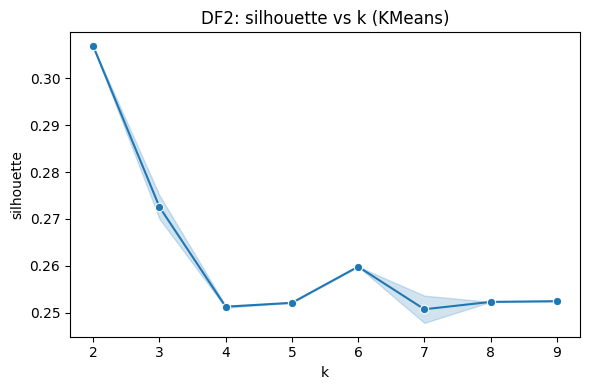

In [76]:
plot_silhouette_vs_k(
    best_model["df2"]["all_results"],
    "DF2",
    "artifacts/figures/silhouette_k_df2.png"
)

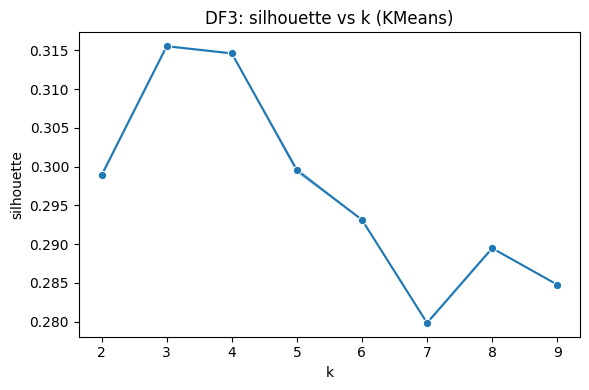

In [77]:
plot_silhouette_vs_k(
    best_model["df3"]["all_results"],
    "DF3",
    "artifacts/figures/silhouette_k_df3.png"
)

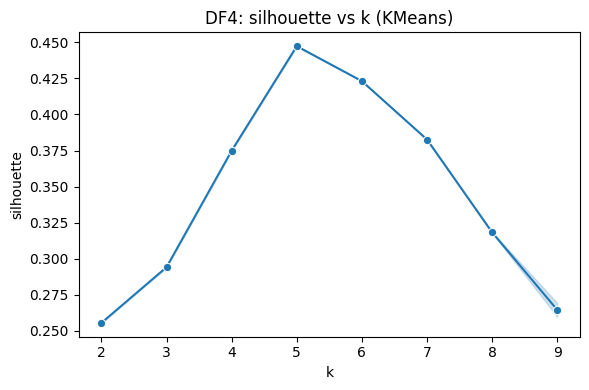

In [78]:
plot_silhouette_vs_k(
    best_model["df4"]["all_results"],
    "DF4",
    "artifacts/figures/silhouette_k_df4.png"
)

In [83]:
mean_ari, std_ari = kmeans_stability(
    Xs["df2"],
    best_model["df2"]["best_model"]["params"]
)

print(f"ARI mean={mean_ari:.3f}, std={std_ari:.3f}")

ARI mean=0.998, std=0.001


In [70]:
metrics_summary = {}
for ds, res in best_model.items():
    metrics_summary[ds] = {}

    for _, row in res["all_results"].iterrows():
        key = f'{row["model"]}_{row["params"]}'
        metrics_summary[ds][key] = {
            "silhouette": row["silhouette"],
            "davies_bouldin": row["davies_bouldin"],
            "calinski_harabasz": row["calinski_harabasz"],
            "noise_ratio": row["noise_ratio"]
        }

with open("artifacts/metrics_summary.json", "w") as f:
    json.dump(metrics_summary, f, indent=2)

In [93]:
best = best_model["df2"]["best_model"]

params = best["params"].copy()

if best["model"] == "kmeans":
    params["n_clusters"] = params.pop("k")
    model = KMeans(**params, random_state=42)

elif best["model"] == "dbscan":
    model = DBSCAN(**params)

elif best["model"] == "agglomerative":
    model = AgglomerativeClustering(**params)

labels = model.fit_predict(Xs["df2"])
labels

array([0, 1, 1, ..., 1, 0, 0], shape=(8000,), dtype=int32)